In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt
import tensorflow as tf
from scipy import signal
from math import ceil
import seaborn as sns
from scipy import stats

In [2]:
def plot_train_history(history, title):
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(len(loss))

    plt.figure()

    plt.plot(epochs, loss, 'b', label='Training loss')
    plt.plot(epochs, val_loss, 'r', label='Validation loss')
    plt.title(title)
    plt.legend()

    plt.show()

In [3]:
def plot_predictions(test,predicted):
    plt.plot(test, color='red',label='Patient Real Heart Rate')
    plt.plot(predicted, color='blue',label='Patient Predicted Heart Rate')
    plt.title('Heart Rate Prediction')
    plt.xlabel('Time')
    plt.ylabel('mV')
    plt.legend()
    plt.show()

def return_rmse(test,predicted):
    mae =mean_absolute_error(test, predicted)
    print(f"The mean absolute error is {mae}.")

In [4]:
def univariate_data(dataset, start_index, end_index, history_size, target_size):
    data = []
    labels = []

    start_index = start_index + history_size
    if end_index is None:
        end_index = len(dataset) - target_size

    for i in range(start_index, end_index):
        indices = range(i-history_size, i)
    # Reshape data from (history_size,) to (history_size, 1)
        data.append(np.reshape(dataset[indices], (history_size, 1)))
        labels.append(dataset[i+target_size])
    return np.array(data), np.array(labels)

In [5]:
def create_time_steps(length):
    return list(range(-length, 0))

In [6]:
def multi_step_plot(history, true_future, prediction):
    plt.figure(figsize=(12, 6))
    num_in = create_time_steps(len(history))
    num_out = len(true_future)

    plt.plot(num_in, np.array(history[:, 1]), label='History',kind='line')
    plt.plot(np.arange(num_out)/STEP, np.array(true_future), 'bo',label='True Future',kind='line')
    if prediction.any():
        plt.plot(np.arange(num_out)/STEP, np.array(prediction), 'ro')
    plt.legend(loc='upper left')
    plt.show()

In [7]:
tf.random.set_seed(13)

In [8]:
df = pd.read_csv('../../data/raw/parabola.csv', index_col='x')
df.head()

,fx
x,
-500,250000
-499,249001
-498,248004
-497,247009
-496,246016


In [9]:
int(df.shape[0] * 0.5)

500

In [10]:
df.tail(5)

,fx
x,
496,246016
497,247009
498,248004
499,249001
500,250000


## Training for 60% of the base

In [11]:
train = df.iloc[0:int(df.shape[0]*0.5)].values

In [12]:
test = df.iloc[int(df.shape[0]*0.5):].values

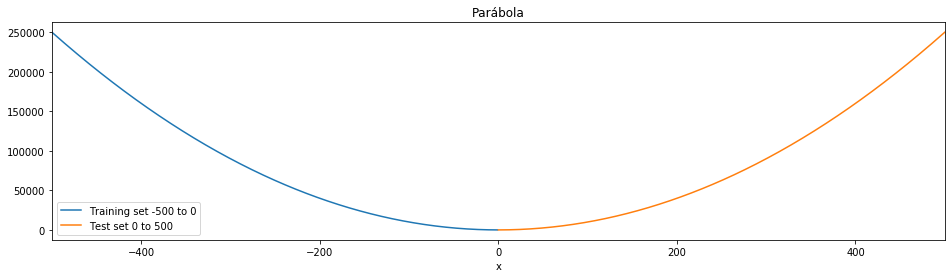

In [42]:
df["fx"].iloc[0:int(df.shape[0]*0.5)].plot(figsize=(16,4),legend=True)
df["fx"].iloc[int(df.shape[0]*0.5):].plot(figsize=(16,4),legend=True)
plt.legend([f'Training set -500 to 0',f'Test set 0 to 500'])
plt.title('Parábola')
plt.show()

In [16]:
uni_data = df['fx']
uni_data.head()

x
-500    250000
-499    249001
-498    248004
-497    247009
-496    246016
Name: fx, dtype: int64

In [17]:
uni_data = uni_data.values

In [18]:
uni_train_mean = uni_data[:int(df.shape[0]*0.5)].mean()
uni_train_std = uni_data[:int(df.shape[0]*0.5)].std()

In [19]:
uni_train_mean

83583.5

In [20]:
uni_train_std

74675.17566802238

Let's standardize the data.

In [21]:
uni_data = (uni_data-uni_train_mean)/uni_train_std

In [22]:
univariate_past_history = 20
univariate_future_target = 0

x_train_uni, y_train_uni = univariate_data(uni_data, 0, int(df.shape[0]*0.5),
                                           univariate_past_history,
                                           univariate_future_target)
x_val_uni, y_val_uni = univariate_data(uni_data, int(df.shape[0]*0.5), None,
                                       univariate_past_history,
                                       univariate_future_target)

In [23]:
y_train_uni

array([ 1.96606836e+00,  1.95322607e+00,  1.94041057e+00,  1.92762185e+00,
        1.91485991e+00,  1.90212475e+00,  1.88941638e+00,  1.87673479e+00,
        1.86407998e+00,  1.85145196e+00,  1.83885071e+00,  1.82627625e+00,
        1.81372858e+00,  1.80120768e+00,  1.78871357e+00,  1.77624624e+00,
        1.76380569e+00,  1.75139193e+00,  1.73900495e+00,  1.72664475e+00,
        1.71431133e+00,  1.70200470e+00,  1.68972485e+00,  1.67747178e+00,
        1.66524550e+00,  1.65304599e+00,  1.64087327e+00,  1.62872734e+00,
        1.61660818e+00,  1.60451581e+00,  1.59245022e+00,  1.58041141e+00,
        1.56839939e+00,  1.55641415e+00,  1.54445569e+00,  1.53252401e+00,
        1.52061912e+00,  1.50874101e+00,  1.49688968e+00,  1.48506514e+00,
        1.47326737e+00,  1.46149639e+00,  1.44975220e+00,  1.43803478e+00,
        1.42634415e+00,  1.41468030e+00,  1.40304323e+00,  1.39143295e+00,
        1.37984945e+00,  1.36829273e+00,  1.35676279e+00,  1.34525964e+00,
        1.33378327e+00,  

# Model testing

In [52]:
multi_step_model = tf.keras.models.Sequential()
multi_step_model.add(tf.keras.layers.LSTM(32,
                                          return_sequences=True,
                                          input_shape=x_train_uni.shape[-2:]))
multi_step_model.add(tf.keras.layers.LSTM(16, activation='relu'))
multi_step_model.add(tf.keras.layers.Dense(1))

multi_step_model.compile(optimizer=tf.keras.optimizers.RMSprop(clipvalue=1.0), loss='mse')

In [53]:
train_data_multi = tf.data.Dataset.from_tensor_slices((x_train_uni, y_train_uni))
train_data_multi = train_data_multi.cache().shuffle(100).batch(500).repeat()

val_data_multi = tf.data.Dataset.from_tensor_slices((x_val_uni, y_val_uni))
val_data_multi = val_data_multi.batch(500).repeat()

In [54]:
multi_step_history = multi_step_model.fit(train_data_multi, epochs=10,
                                          steps_per_epoch=100,
                                          validation_data=val_data_multi,
                                          validation_steps=50)

Train for 100 steps, validate for 50 steps
Epoch 1/10
100/100 [==============================] - 5s 51ms/step - loss: 0.1000 - val_loss: 0.0186
Epoch 2/10
100/100 [==============================] - 3s 31ms/step - loss: 0.0033 - val_loss: 0.0246
Epoch 3/10
100/100 [==============================] - 3s 31ms/step - loss: 0.0027 - val_loss: 0.0313
Epoch 4/10
100/100 [==============================] - 3s 31ms/step - loss: 0.0024 - val_loss: 0.0206
Epoch 5/10
100/100 [==============================] - 3s 31ms/step - loss: 0.0020 - val_loss: 0.0249
Epoch 6/10
100/100 [==============================] - 3s 31ms/step - loss: 0.0019 - val_loss: 0.0289
Epoch 7/10
100/100 [==============================] - 3s 30ms/step - loss: 0.0017 - val_loss: 0.0179
Epoch 8/10
100/100 [==============================] - 3s 30ms/step - loss: 0.0016 - val_loss: 0.0189
Epoch 9/10
100/100 [==============================] - 3s 31ms/step - loss: 0.0014 - val_loss: 0.0192
Epoch 10/10
100/100 [===========================

## Multi-Step Training

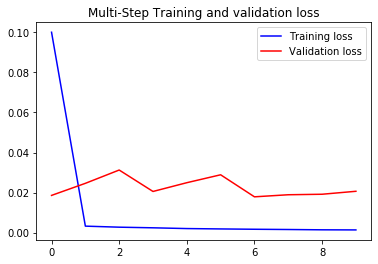

In [55]:
plot_train_history(multi_step_history, 'Multi-Step Training and validation loss')

In [60]:
STEP = 1

result for ks on test is KstestResult(statistic=0.13265293838901226, pvalue=7.674267053812097e-08)
result for ks on prediction is KstestResult(statistic=0.9745951429479064, pvalue=0.0)
Results for spearman correlation is SpearmanrResult(correlation=1.0, pvalue=0.0)


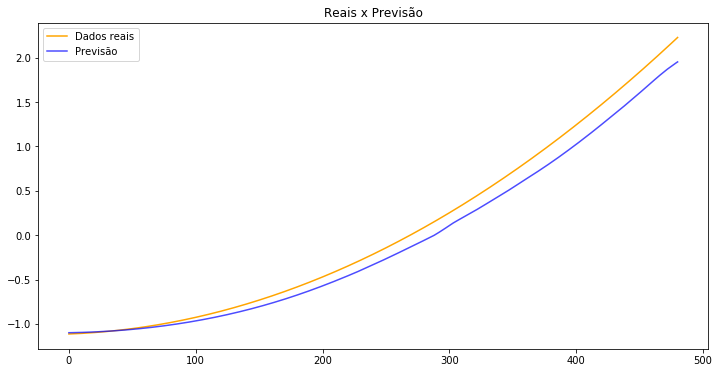

In [65]:
for x, y in val_data_multi.take(1):
    num_in = create_time_steps(len(x))
    num_out = len(y)
    prediction = multi_step_model.predict(x)
    
    ks_test = stats.kstest(np.array(y),'norm')
    ks_pred = stats.kstest(np.array(prediction),'norm')
    
    print(f'result for ks on test is {ks_test}')
    print(f'result for ks on prediction is {ks_pred}')
    
    if (ks_test[1] >=0.05) and (ks_pred[1] >= 0.05):
        print(f'Results for pearson correlation is {stats.pearsonr(np.array(pd.DataFrame(y)[0]),np.array(pd.DataFrame(prediction)[0]))}')
    else:
        print(f'Results for spearman correlation is {stats.spearmanr((np.array(pd.DataFrame(y)[0])),(np.array(pd.DataFrame(prediction)[0])))}')
        #pass
    
    plt.figure(figsize=(12, 6))
    #plt.plot(num_in, np.array(x[:, 1]), label='History')
    plt.plot(np.arange(num_out)/STEP, np.array(y),label='True Future',color='orange')
    if prediction.any():
        plt.plot(np.arange(num_out)/STEP, np.array(prediction),color='blue',alpha=0.7)
    plt.legend(['Dados reais','Previsão'])
    plt.title('Reais x Previsão')
    plt.show()

In [63]:
x

<tf.Tensor: id=55740, shape=(481, 20, 1), dtype=float64, numpy=
array([[[-1.11929432],
        [-1.11928093],
        [-1.11924076],
        ...,
        [-1.11542423],
        [-1.11495553],
        [-1.11446005]],

       [[-1.11928093],
        [-1.11924076],
        [-1.1191738 ],
        ...,
        [-1.11495553],
        [-1.11446005],
        [-1.11393779]],

       [[-1.11924076],
        [-1.1191738 ],
        [-1.11908006],
        ...,
        [-1.11446005],
        [-1.11393779],
        [-1.11338874]],

       ...,

       [[ 1.94041057],
        [ 1.95322607],
        [ 1.96606836],
        ...,
        [ 2.16191657],
        [ 2.17518738],
        [ 2.18848498]],

       [[ 1.95322607],
        [ 1.96606836],
        [ 1.97893743],
        ...,
        [ 2.17518738],
        [ 2.18848498],
        [ 2.20180935]],

       [[ 1.96606836],
        [ 1.97893743],
        [ 1.99183328],
        ...,
        [ 2.18848498],
        [ 2.20180935],
        [ 2.21516051]]])>

In [35]:
x_train_uni[0]

array([[2.22853845],
       [2.21516051],
       [2.20180935],
       [2.18848498],
       [2.17518738],
       [2.16191657],
       [2.14867255],
       [2.1354553 ],
       [2.12226484],
       [2.10910117],
       [2.09596427],
       [2.08285416],
       [2.06977083],
       [2.05671428],
       [2.04368451],
       [2.03068153],
       [2.01770533],
       [2.00475591],
       [1.99183328],
       [1.97893743]])

In [36]:
y_train_uni[0]

1.9660683578796079

In [38]:
x_val_uni[0]

array([[-1.11929432],
       [-1.11928093],
       [-1.11924076],
       [-1.1191738 ],
       [-1.11908006],
       [-1.11895954],
       [-1.11881223],
       [-1.11863815],
       [-1.11843728],
       [-1.11820962],
       [-1.11795519],
       [-1.11767397],
       [-1.11736597],
       [-1.11703119],
       [-1.11666962],
       [-1.11628127],
       [-1.11586614],
       [-1.11542423],
       [-1.11495553],
       [-1.11446005]])

In [39]:
y_val_uni[0]

-1.1139377879712318

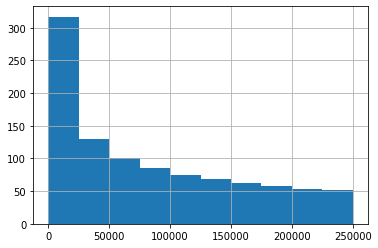

In [40]:
df['fx'].hist()

In [43]:
train_data_multi

<RepeatDataset shapes: ((None, 20, 1), (None,)), types: (tf.float64, tf.float64)>

In [45]:
for x,y in train_data_multi.take(1):
    x

In [47]:
y

<tf.Tensor: id=35485, shape=(480,), dtype=float64, numpy=
array([ 1.00194609e+00,  1.81372858e+00,  1.61660818e+00,  9.07095288e-01,
        8.55337794e-01,  1.23170115e+00,  1.70200470e+00,  1.28814561e+00,
        1.77624624e+00,  1.07721876e+00,  1.80120768e+00,  1.05557837e+00,
        1.06638517e+00,  1.85145196e+00,  1.88941638e+00,  1.17592626e+00,
        9.59522349e-01,  9.80680653e-01,  7.23901879e-01,  7.94112628e-01,
        1.55641415e+00,  6.64765761e-01,  1.42634415e+00,  1.87673479e+00,
        1.41468030e+00,  9.38471177e-01,  1.37984945e+00,  1.68972485e+00,
        5.58853724e-01,  1.49688968e+00,  1.20931085e+00,  1.35676279e+00,
        1.50874101e+00,  9.70088110e-01,  1.22049261e+00,  5.77869414e-01,
        6.16222186e-01,  1.53252401e+00,  6.06593819e-01,  1.48506514e+00,
        1.32233368e+00,  6.55003481e-01,  6.45267983e-01,  7.43828180e-01,
        5.96992235e-01,  1.34525964e+00,  5.02449437e-01,  1.16485163e+00,
        1.02331865e+00,  4.37863048e-01,  